In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from xgboost import XGBRegressor
from xgboost import plot_importance
import pickle

In [2]:
train = pd.read_csv('sales_train_v1.csv')
if 'Unnamed: 0' in train.columns:
    train.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
train['month'] = train['month'].apply(lambda x: int(x))

In [54]:
#train['shop_id'] = train['shop_id'].apply(lambda x: str(x))
#train['item_id'] = train['item_id'].apply(lambda x: str(x))
#train['item_category_id'] = train['item_category_id'].apply(lambda x: str(x))

In [5]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
train['month_1hot'] = lb.fit_transform(train['month']).tolist()

In [6]:
train.head()

,date_block_num,shop_id,item_id,item_price,month,item_cnt_month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_3block_avg,item_price_lag_1,item_category,shop_category,month_1hot
0,0,0,32,221.0,1,6.0,40,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,0,0,33,347.0,1,3.0,37,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,0,0,35,247.0,1,1.0,40,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,0,0,43,221.0,1,1.0,40,NaN,NaN,NaN,NaN,NaN,NaN,Кино,!Якутск,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,0,0,51,128.5,1,2.0,57,NaN,NaN,NaN,NaN,NaN,NaN,Музыка,!Якутск,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
mons = train['month_1hot'].apply(pd.Series)

In [ ]:
mons = mons.rename(columns = lambda x : 'mon_' + str(x))
pd.concat([train[:], mons[:]], axis=1)
train = train.drop(['month_1hot'], axis=1)

In [56]:
#max(train['date_block_num'])

In [4]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train[train.date_block_num < 33]['item_cnt_month']
X_valid = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train[train.date_block_num == 33]['item_cnt_month']

In [5]:
X_train = X_train.drop(['item_category', 'shop_category','item_cnt_month_3block_avg'], axis=1)
X_valid = X_valid.drop(['item_category', 'shop_category','item_cnt_month_3block_avg'], axis=1)                                            

In [6]:
X_train.head()

,date_block_num,shop_id,item_id,item_price,month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_price_lag_1
0,0,0,32,221.0,1.0,40,NaN,NaN,NaN,NaN,NaN
1,0,0,33,347.0,1.0,37,NaN,NaN,NaN,NaN,NaN
2,0,0,35,247.0,1.0,40,NaN,NaN,NaN,NaN,NaN
3,0,0,43,221.0,1.0,40,NaN,NaN,NaN,NaN,NaN
4,0,0,51,128.5,1.0,57,NaN,NaN,NaN,NaN,NaN


In [60]:
#ts = time.time()


model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

#time.time() - ts

[23:51:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:08] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.934462	validation_1-rmse:0.633999
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.901408	validation_1-rmse:0.579413
[2]	validation_0-rmse:0.873823	validation_1-rmse:0.542986
[3]	validation_0-rmse:0.860771	validation_1-rmse:0.524892
[4]	validation_0-rmse:0.848561	validation_1-rmse:0.494618
[5]	validation_0-rmse:0.840213	validation_1-rmse:0.470826
[6]	validation_0-rmse:0.820501	validation_1-rmse:0.451734
[7]	validation_0-rmse:0.806771	validation_1-rmse:0.432339
[8]	validation_0-rmse:0.792955	validation_1-rmse:0.419736


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

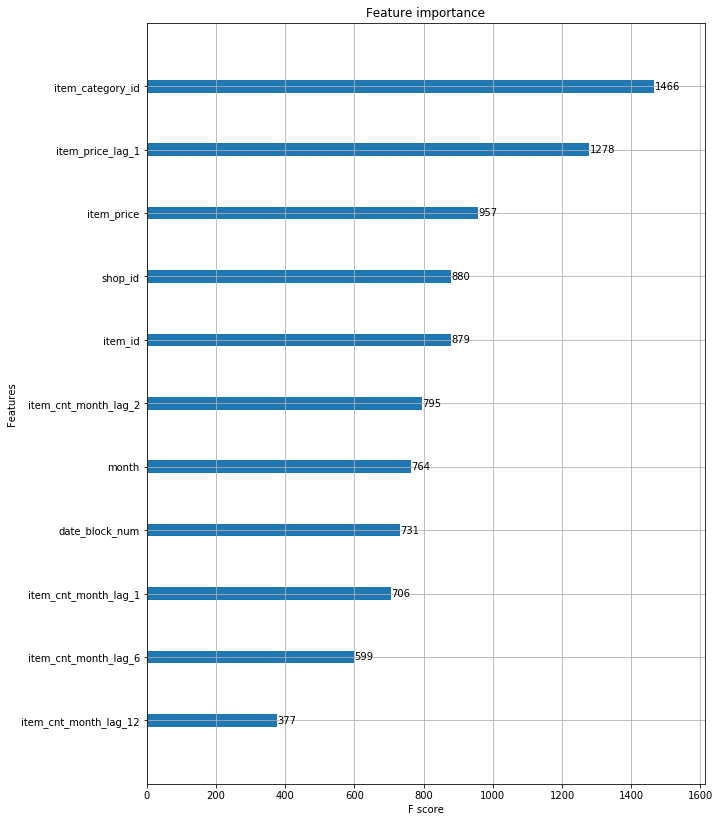

In [61]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))

In [4]:

#pickle.dump(model, open("train.pickle.dat", "wb"))

In [7]:
X_train.head()

,date_block_num,shop_id,item_id,item_price,month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_price_lag_1
0,0,0,32,221.0,1.0,40,NaN,NaN,NaN,NaN,NaN
1,0,0,33,347.0,1.0,37,NaN,NaN,NaN,NaN,NaN
2,0,0,35,247.0,1.0,40,NaN,NaN,NaN,NaN,NaN
3,0,0,43,221.0,1.0,40,NaN,NaN,NaN,NaN,NaN
4,0,0,51,128.5,1.0,57,NaN,NaN,NaN,NaN,NaN


In [8]:
Y_train.head()

0    6.0
1    3.0
2    1.0
3    1.0
4    2.0
Name: item_cnt_month, dtype: float64

In [11]:
# load model from file
loaded_model = pickle.load(open("train.pickle.dat", "rb"))

[19:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [12]:
y_pred = loaded_model.predict(X_valid)

In [13]:
X_valid['predicted_count'] = y_pred.tolist()

In [15]:
X_valid['predicted_count'] = X_valid['predicted_count'].round(decimals=0)

In [16]:
X_valid.head()

,date_block_num,shop_id,item_id,item_price,month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_price_lag_1,predicted_count
1561127,33,2,31,399.0,10.0,37,0.0,0.0,0.0,0.0,699.3,0.0
1561128,33,2,486,300.0,10.0,73,1.0,0.0,1.0,1.0,300.0,1.0
1561129,33,2,787,420.0,10.0,49,0.0,0.0,0.0,0.0,699.3,0.0
1561130,33,2,794,3300.0,10.0,73,0.0,0.0,0.0,0.0,699.3,1.0
1561131,33,2,968,58.0,10.0,40,0.0,0.0,0.0,0.0,699.3,1.0


In [17]:
X_valid['actual_count'] = Y_valid.tolist()

In [18]:
X_valid.head()

,date_block_num,shop_id,item_id,item_price,month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_6,item_cnt_month_lag_12,item_price_lag_1,predicted_count,actual_count
1561127,33,2,31,399.0,10.0,37,0.0,0.0,0.0,0.0,699.3,0.0,1.0
1561128,33,2,486,300.0,10.0,73,1.0,0.0,1.0,1.0,300.0,1.0,3.0
1561129,33,2,787,420.0,10.0,49,0.0,0.0,0.0,0.0,699.3,0.0,1.0
1561130,33,2,794,3300.0,10.0,73,0.0,0.0,0.0,0.0,699.3,1.0,1.0
1561131,33,2,968,58.0,10.0,40,0.0,0.0,0.0,0.0,699.3,1.0,1.0


In [77]:
#X_vis.to_csv('vis.csv')

In [24]:
df = X_valid.loc[:, X_valid.columns.intersection(['date_block_num','predicted_count', 'actual_count', 'item_id','shop_id'])]

In [25]:
df.head()

,date_block_num,shop_id,item_id,predicted_count,actual_count
1561127,33,2,31,0.0,1.0
1561128,33,2,486,1.0,3.0
1561129,33,2,787,0.0,1.0
1561130,33,2,794,1.0,1.0
1561131,33,2,968,1.0,1.0


In [26]:
df.shape

(1330200, 5)

In [27]:
df = df[(df['actual_count'] != 0) | (df['predicted_count'] != 0)]

In [28]:
df.head()

,date_block_num,shop_id,item_id,predicted_count,actual_count
1561127,33,2,31,0.0,1.0
1561128,33,2,486,1.0,3.0
1561129,33,2,787,0.0,1.0
1561130,33,2,794,1.0,1.0
1561131,33,2,968,1.0,1.0


In [29]:
df.shape

(36669, 5)

In [34]:
df['difference_in_prediction'] = (df['actual_count'] - df['predicted_count']).abs()

In [35]:
df.head()

,date_block_num,shop_id,item_id,predicted_count,actual_count,difference_in_prediction
1561127,33,2,31,0.0,1.0,1.0
1561128,33,2,486,1.0,3.0,2.0
1561129,33,2,787,0.0,1.0,1.0
1561130,33,2,794,1.0,1.0,0.0
1561131,33,2,968,1.0,1.0,0.0


In [39]:
df = df[df['actual_count'] < 15 ]

In [46]:
df['actual_count'] = df['actual_count'].apply(lambda x: int(x))

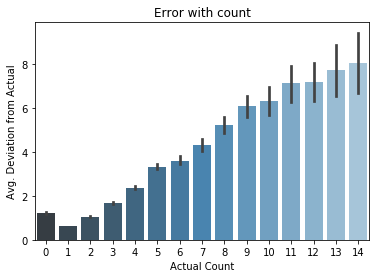

In [48]:
p = sns.barplot(x = 'actual_count', y = 'difference_in_prediction', data = df, palette="Blues_d")
p.set_title("Error with count")
p.set(xlabel='Actual Count', ylabel='Avg. Deviation from Actual')
plt.savefig('Difference in Prediction.pdf')
plt.show()

In [43]:
ac_cnt =  df.groupby(by=['actual_count']).agg('mean')['difference_in_prediction']
ac_cnt = ac_cnt.reset_index()

In [44]:
ac_cnt

,actual_count,difference_in_prediction
0,0.0,1.226741
1,1.0,0.613456
2,2.0,1.041262
3,3.0,1.684486
4,4.0,2.372951
5,5.0,3.318333
6,6.0,3.599424
7,7.0,4.316667
8,8.0,5.230303
9,9.0,6.070312
